In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
import sys
sys.path.append('../')

# from scripts.compute_decoupled_cl import compute_decoupled_cl
# from scripts.apply_HILC import apply_HILC
from scripts.cosine_smoothed_mask import cosine_smoothed_mask
from scripts.compute_cl import compute_cl


In [2]:
from scripts.compute_master import compute_master
from scripts.compute_weights import compute_weights
from scripts.mask_maps import mask_maps
from scripts.compute_alm_ilc import compute_alm_ilc



def apply_HILC(map_in:np.ndarray, mask, nside, lmax, nfreqs)->np.ndarray:
    
    """
    Applies the HILC algorithim to input maps
    
    Parameters:
        map_in (np.ndarray): input maps

    Returns:
        clean_maps (np.ndarray): _description_
    """
    
    alm_size=hp.Alm.getsize(lmax)
    npix=hp.nside2npix(nside)
    
    mask= (mask*(-1))+1
    cl_dec= compute_master(map_in[:nfreqs], mask, False, nside, lmax, nfreqs)
    weights = compute_weights(nfreqs, lmax, cl_dec)

    masked_maps, alms_masked= mask_maps(map_in[:nfreqs], mask, alm_size,lmax, nfreqs, npix)
    alm_ilc=compute_alm_ilc(alms_masked, alm_size, weights, lmax)
    clean_maps = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)
    clean_maps=np.tile(clean_maps, (1, nfreqs))
    clean_maps = clean_maps.reshape(nfreqs, npix)
    print("Cleaned maps")
    hilc= compute_master(clean_maps[:nfreqs], mask, True, nside, lmax, nfreqs)
    
    return cl_dec,hilc

In [10]:
smoothed_hi_maps=np.load("smoothed_hi_maps.npy")

In [4]:
nside=256
factor=1e7
npix=hp.nside2npix(nside)
# freqs=np.arange(544,1088,step=1)
nfreqs=5
# shells= nfreqs-1
lmax=3*nside -1
D=13.5 #size of dish in meteres

In [58]:
fakemask=np.zeros(npix)
mask= cosine_smoothed_mask(nside)

Masked Sky HILC

In [59]:
dec, hilc=apply_HILC(smoothed_hi_maps, mask, nside, lmax, nfreqs)

Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4
Cleaned maps
Decoupling map 0
Decoupling map 1
Decoupling map 2
Decoupling map 3
Decoupling map 4


In [60]:
# dec_full, hilc_full=apply_HILC(smoothed_hi_maps, fakemask, nside, lmax, nfreqs)

In [6]:
ells = np.arange(2, lmax+1)

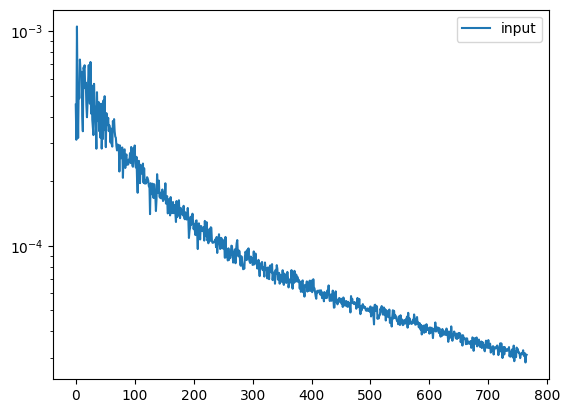

In [13]:
input=hp.anafast(smoothed_hi_maps[0])
# print(input)
# plt.plot(ells,hilc[:,0,0]*nfreqs, label="hilc")
plt.plot(input[2:], label="input")
# plt.plot(ells, dec[:,0,0], label="dec")
plt.yscale('log')
# plt.ylim(1e-5, 1e-2)
# plt.xlim(-10, 800)
plt.legend()

(-5.0, 5.0)

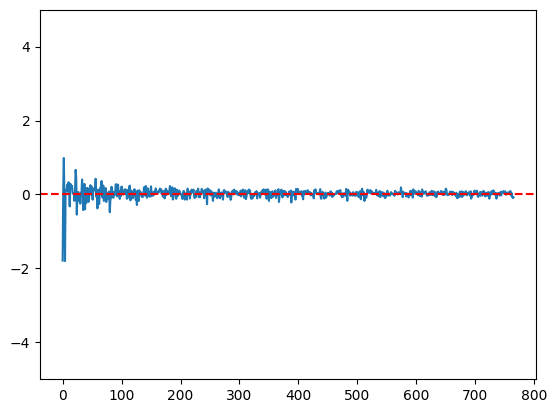

In [75]:
plt.plot((dec[:,0,0]-hilc[:,0,0]*nfreqs)/dec[:,0,0])
plt.axhline(0, color='r', linestyle='--')
# plt.xscale("log")
plt.ylim(-5, 5)

In [63]:
# input=hp.anafast(smoothed_hi_maps[0])
# plt.plot(ells,hilc_full[:,0,0]*nfreqs, label="hilc")
# # plt.plot(input[2:], label="input")
# plt.plot(ells, dec_full[:,0,0], label="dec")
# plt.yscale('log')
# plt.legend()

In [14]:
almsize=hp.Alm.getsize(lmax)

Full Sky HILC

In [15]:
alm_maps=np.zeros((nfreqs, almsize), dtype=complex) 
for nf in range(nfreqs):
    print(f"Converting maps {nf}")
    alm_maps[nf,:]= hp.map2alm(smoothed_hi_maps[nf,:], lmax=lmax, mmax=None, iter=0, pol=False) 
alm_p, C_l=compute_cl(alm_maps, lmax, nfreqs)
weights = compute_weights(nfreqs, lmax, C_l)
alm_ilc=compute_alm_ilc(alm_maps, almsize, weights, lmax)
maps_out = hp.alm2map(alm_ilc, nside, lmax=lmax, mmax=None)

Converting maps 0
Converting maps 1
Converting maps 2
Converting maps 3
Converting maps 4


In [24]:
C_l.shape

(768, 5, 5)

In [16]:
alm_ilc.shape

(295296,)

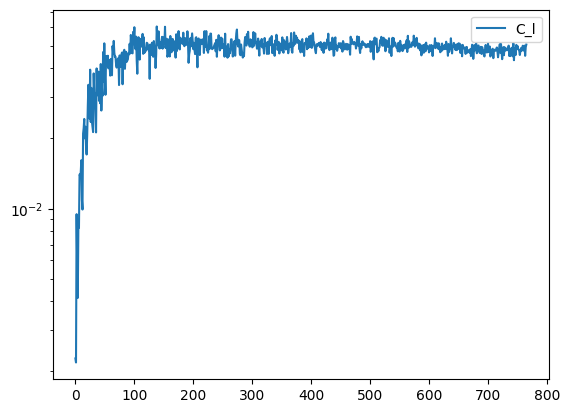

In [28]:
cl_fsky=hp.anafast(maps_out)
# input=hp.anafast(smoothed_hi_maps[0])
# plt.plot(cl_fsky[2:]*nfreqs, label="hilc")
# plt.plot(input[2:], label="input")
plt.plot(C_l[2:,0,0], label="C_l")
plt.yscale('log')
plt.legend()
# np.allclose(cl_f, cl_fsky)

In [26]:
print(input.shape)

(768,)


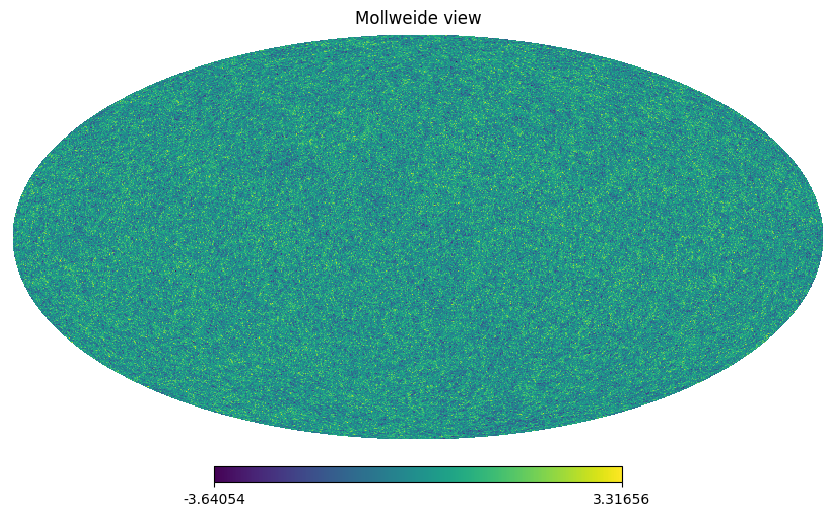

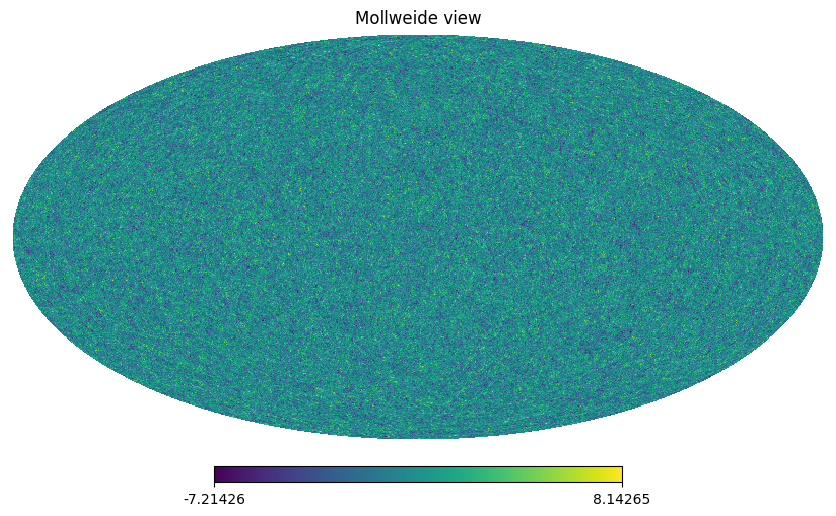

In [79]:
hp.mollview(maps_out)
hp.mollview(smoothed_hi_maps[0])